In [362]:
import torch
from torchvision import models, datasets, transforms
from torch import nn, optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F
import PIL
import matplotlib.pyplot as plt

In [363]:
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [364]:
for parameters in model.parameters():
    parameters.requires_grad = False
model.features[32] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
model.features[34] = nn.Conv2d(512, 10, kernel_size=3, stride=1, padding=1)
model.avgpool = nn.AdaptiveAvgPool2d(1)  #生成 (10, 1, 1)的输出 10是n_channels 
model.classifier = nn.Linear(10, 10)

In [365]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [366]:
parameters = list(model.parameters())[-2]
print(parameters.shape)

torch.Size([10, 10])


In [367]:
class WrappedDataLoader:
    def __init__(self, dataloader, function):
        self.dataloader = dataloader
        self.function = function

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        batches = iter(self.dataloader)
        for batch in batches:
            yield (self.function(*batch))

In [368]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = datasets.STL10('data', split="train", transform=train_transforms, download=True)
validation_dataset = datasets.STL10('data', split="test", transform=validation_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


classes:  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
test label:dog ;; label index:5


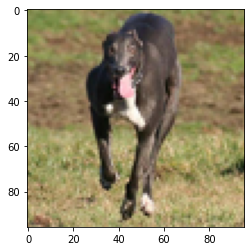

In [369]:
index = 1  # train_dataset.data.shape (5000, 3, 96, 96)
test_data = train_dataset.data[index]
test_data = test_data.transpose(1, 2, 0)  # 96, 96, 3
test_label = train_dataset.classes[train_dataset.labels[index]]
print("classes: ", train_dataset.classes)
print("test label:{} ;; label index:{}".format(test_label, train_dataset.labels[index]))
plt.figure()
plt.imshow(test_data)
plt.show()

In [370]:
def train_batch_loss(model, loss_function, x, y, opt=None):
    loss = loss_function(model(x), y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return np.array(loss.item()), np.array(len(x))

In [371]:
def valid_batch_loss(model, loss_function, x, y):
    output = model(x)
    loss = loss_function(output, y)
    prediction = torch.argmax(output, dim=1)  # 按行找最大的索引 dim-0按列
    correction = prediction == y.view(*prediction.shape)
    correction_account = torch.sum(correction).item()
    return np.array(loss.item()), correction_account, np.array(len(x))

In [372]:
def training(epochs, model, loss_function, optimizer, train_data, validation_data):
    for epoch in range(epochs):
        # train 
        model.train()
        loss, number_of_data = zip(*[train_batch_loss(model, loss_function, x, y, optimizer) for x, y in train_loader])
        train_loss = np.sum(np.multiply(loss,number_of_data)) / np.sum(number_of_data)
        # evaluate validation dataset
        model.eval()
        with torch.no_grad():
            loss, correction_account, number_of_data = zip(*[valid_batch_loss(model, loss_function, x, y) for x, y in validation_loader])
            validation_loss = np.sum(np.multiply(loss, number_of_data)) / np.sum(number_of_data)
            validation_accuracy = np.sum(correction_account) / np.sum(number_of_data) * 100
            print("[Epoch {}/{} Train loss:{:.6f}]\t Validation loss:{:.6f}\t Validation accuracy:{:.3f}%".format(epoch+1, 
                                                                                                                  epochs,
                                                                                                                  train_loss,
                                                                                                                  validation_loss,
                                                                                                                  validation_accuracy)
                 )
            

In [273]:
device = torch.device("cuda")


def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)


train_loader = WrappedDataLoader(train_loader, to_device)
validation_loader = WrappedDataLoader(validation_loader, to_device)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

training(epochs, model, criterion, optimizer, train_loader, validation_loader)

[Epoch 1/20 Train loss:0.765927]	 Validation loss:0.393531	 Validation accuracy:90.325%
[Epoch 2/20 Train loss:0.608526]	 Validation loss:0.324160	 Validation accuracy:91.287%
[Epoch 3/20 Train loss:0.574902]	 Validation loss:0.302015	 Validation accuracy:91.513%
[Epoch 4/20 Train loss:0.546026]	 Validation loss:0.296233	 Validation accuracy:91.400%
[Epoch 5/20 Train loss:0.553547]	 Validation loss:0.276899	 Validation accuracy:92.287%
[Epoch 6/20 Train loss:0.531299]	 Validation loss:0.274638	 Validation accuracy:92.062%
[Epoch 7/20 Train loss:0.523635]	 Validation loss:0.280353	 Validation accuracy:92.100%
[Epoch 8/20 Train loss:0.533187]	 Validation loss:0.291921	 Validation accuracy:91.575%
[Epoch 9/20 Train loss:0.535656]	 Validation loss:0.278795	 Validation accuracy:92.038%
[Epoch 10/20 Train loss:0.506317]	 Validation loss:0.260556	 Validation accuracy:92.287%
[Epoch 11/20 Train loss:0.498693]	 Validation loss:0.245479	 Validation accuracy:92.775%
[Epoch 12/20 Train loss:0.4872

In [274]:
torch.save(model, r"D:\PYHTON\python3.7\DeepLearningProgram\Class_activation_mapping\fine_tuned_vgg-19.pt")

In [373]:
save_path = r"D:\PYHTON\python3.7\DeepLearningProgram\Class_activation_mapping\fine_tuned_vgg-19.pt"
device = torch.device("cuda")
model = torch.load(save_path, map_location=device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [378]:
def CAM(feature_map, weights):
    upsample_size = (96, 96)
    number_class, nc = weights.shape
    (n_c, h, w) = feature_map.shape  # n_b = 1;  n_c = 10  weighst = (10, 10)
    cam = weights @ feature_map.reshape((n_c, h*w))
    cam = cam.reshape(number_class, h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255*cam_img)
    cam_img = cam.transpose(1, 2, 0)
    cam_img = cv2.resize(cam_img, upsample_size)
    return cam_img    

In [ ]:
class get_feature_map:
    features = None
    
    def __init__(self, model):
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

In [380]:
def predict_one_sample(model, x):
    
    x = x[np.newaxis,:, :, :]
    x = torch.from_numpy(x)
    x = x.type(torch.cuda.FloatTensor).to(device)
    
    # get feature map of last convolutional layer
    feature_map = get_feature_map(model.features[-3])
    logits = model(x)
    feature_map.remove()
    feature_map = feature_map.features.cpu().detach().numpy().squeeze()
    
    # get weights of linear layer before softmax (因为-1层是bias, -2层才是对应的weights)
    weights = list(model.parameters())[-2].data.cpu().detach().numpy()  # 
    softmax_result = F.softmax(logits, dim=1).data.squeeze()
    _, idx = softmax_result.sort(0, True)
    idx = idx.cpu().numpy()
    
    return feature_map, weights, idx[0]
      

groud truth:car ;; label index:2
prediction: car ;; prediction index: 2
(96, 96, 10)


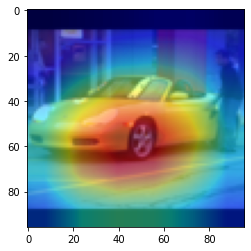

In [429]:
index = 1000 # train_dataset.data.shape (5000, 3, 96, 96)  1000是个很好的展示结果
test_data = train_dataset.data[index]
test_label = train_dataset.classes[train_dataset.labels[index]]
label_index = train_dataset.labels[index]
print("groud truth:{} ;; label index:{}".format(test_label,label_index))

feature_map, weights, pre_index = predict_one_sample(model, test_data)
# print(feature_map.shape)  # (10, 6, 6)
# print(weights.shape)  # (10, 10)

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
# print("prediction: ", test_label)
prediction = classes[pre_index]

print("prediction: {} ;; prediction index: {}".format(prediction, pre_index))
class_activation_map = CAM(feature_map, weights)  # (96, 96, 10)
print(class_activation_map.shape)  # (96, 96, 10)


background_image = test_data.transpose(1, 2, 0)  # (96, 96, 3)

plt.figure()
plt.imshow(background_image)
plt.imshow(class_activation_map[:,:,pre_index], alpha=0.5, cmap='jet')
plt.show()